## Imports

In [2]:
import os
import numpy as np
import pandas as pd
import re
import time
from tqdm import tqdm 
from gensim.models import Word2Vec
#from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import plot_model 
from keras.callbacks import EarlyStopping, TensorBoard
import pretty_midi
import warnings
from sklearn.model_selection import train_test_split
#from plot_keras_history import show_history, plot_history
import seaborn as sns
import math 
from tensorflow.keras.layers import Embedding
from keras import backend as K



## 1. Preprocess

### 1.1. Preprocess

In [3]:
def read_lyrics_set(path):
    columns = ["artist", "song_1", "lyrics_1", "song_2", "lyrics_2", "song_3", "lyrics_3"]
    df = pd.read_csv(path, names=columns, header=None)
    
    # Create an empty DataFrame with the desired columns
    new_df = pd.DataFrame(columns=['artist', 'song', 'lyrics', 'midi_file'])

    # Iterate over the original DataFrame row by row
    for index, row in df.iterrows():
        # Extract the values from the current row
        artist = row['artist']
        song_1 = row['song_1']
        lyrics_1 = row['lyrics_1']
        
        # Add the current row to the new DataFrame
        new_df = pd.concat([new_df, pd.DataFrame({'artist': [artist], 'song': [song_1], 'lyrics': [lyrics_1]})], ignore_index=True)
        
        # Check if song_name_3 is not NaN
        if not pd.isnull(row['song_2']):
            # Extract the values from the next two rows
            song_2 = row['song_2']
            lyrics_2 = row['lyrics_2']
            new_df = pd.concat([new_df, pd.DataFrame({'artist': [artist], 'song': [song_2], 'lyrics': [lyrics_2]})], ignore_index=True)
            
            if not pd.isnull(row['song_3']):
                song_3 = row['song_3']
                lyrics_3 = row['lyrics_3']
                new_df = pd.concat([new_df, pd.DataFrame({'artist': [artist], 'song': [song_3], 'lyrics': [lyrics_3]})], ignore_index=True)
    
    new_df['song'] = new_df['song'].str.strip()
    new_df['artist'] = new_df['artist'].str.strip()
    return new_df


In [4]:
def add_midi_file_name_to_df(df, folder_path):
    # Iterate over the MIDI files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".mid"):
            # Extract the artist and song names from the file name
            artist = filename.split("_-_")[0].lower().replace("_", " ")
            song = filename.split("_-_")[1].lower().replace("_", " ").replace(".mid", "")
            # Find the matching row in the DataFrame by artist and song
            match_row = df[(df['artist'].str.lower() == artist) & (df['song'].str.lower() == song)]
            # Check if a match is found
            if not match_row.empty:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    try:
                        # Attempt to load the MIDI file
                        pretty_midi.PrettyMIDI(f"{folder_path}/{filename}")

                        # Get the index of the match row
                        match_index = match_row.index[0]

                        # Update the "midi_file" column with the original MIDI file name
                        df.at[match_index, 'midi_file'] = filename
                    except:
                        print(f"Error processing MIDI file: {filename}")

    # Remove rows with NaN or None values
    df = df.dropna()

    # Reset the index after removing rows
    df = df.reset_index(drop=True)

    return df


In [5]:
def replace_words(text):
    replacements = {
    r"\bisn't\b": "is not",
    r"\bwon't\b": "will not",
    r"\baren't\b": "are not",
    r"\bwasn't\b": "was not",
    r"\bweren't\b": "were not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bcan't\b": "cannot",
    r"\bcouldn't\b": "could not",
    r"\bshouldn't\b": "should not",
    r"\bwouldn't\b": "would not",
    r"\bmightn't\b": "might not",
    r"\bmustn't\b": "must not",
    r"\bI'm\b": "I am",
    r"\byou're\b": "you are",
    r"\bhe's\b": "he is",
    r"\bshe's\b": "she is",
    r"\bit's\b": "it is",
    r"\bwe're\b": "we are",
    r"\bthey're\b": "they are",
    r"\bi've\b": "I have",
    r"\byou've\b": "you have",
    r"\bwe've\b": "we have",
    r"\bthey've\b": "they have",
    r"\bi'd\b": "I would",
    r"\byou'd\b": "you would",
    r"\bhe'd\b": "he would",
    r"\bshe'd\b": "she would",
    r"\bit'd\b": "it would",
    r"\bwe'd\b": "we would",
    r"\bthey'd\b": "they would",
    r"\bi'll\b": "I will",
    r"\byou'll\b": "you will",
    r"\bhe'll\b": "he will",
    r"\bshe'll\b": "she will",
    r"\bit'll\b": "it will",
    r"\bwe'll\b": "we will",
    r"\bthey'll\b": "they will",
}

    # Apply the replacements
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)

    # Split the text into individual words
    words = text.split()

    # Filter out the '&' symbol
    words = [word for word in words if word != "&"]

    return words

In [6]:
def clean_words(words):
    """
    Cleans a list of words by removing any non-alphabetic characters from each word.

    Args:
        words (list): A list of words to be cleaned.

    Returns:
        list: A list of cleaned words.
    """
    cleaned_words = []
    for word in words:
        cleaned_word = re.sub(r'[^a-zA-Z]', '', word)
        cleaned_words.append(cleaned_word)
    return cleaned_words

In [7]:
def create_lyrics_tokens(df):
    """
    Creates a new DataFrame column with tokenized lyrics by processing the existing lyrics column.

    Args:
        df (pandas.DataFrame): The input DataFrame containing columns 'artist', 'song', 'lyrics', 'midi_file'.

    Returns:
        pandas.DataFrame: A new DataFrame with an additional column 'lyrics_tokens' containing tokenized lyrics.
 
    """

    df2 = pd.DataFrame(columns=['artist', 'song', 'lyrics', 'midi_file', 'lyrics_tokens'])

    new_df = pd.concat([df, df2], ignore_index=True)

    for index, row in new_df.iterrows():
        tokens = replace_words(row['lyrics'].lower())
        tokens = clean_words(tokens)
        new_df.at[index, 'lyrics_tokens'] = tokens

    return new_df


#### Train, test, validation sets

In [8]:
path = r'lyrics_train_set.csv'
folder_path = r'midi_files'
train_df = read_lyrics_set(path)
train_df = add_midi_file_name_to_df(train_df, folder_path)
train_df = create_lyrics_tokens(train_df)
train_df

Error processing MIDI file: Aaron_Neville_-_Tell_It_Like_It_Is.mid
Error processing MIDI file: Beastie_Boys_-_Girls.mid
Error processing MIDI file: Billy_Joel_-_Movin'_Out.mid
Error processing MIDI file: Billy_Joel_-_Pressure.mid
Error processing MIDI file: Brian_McKnight_-_On_The_Down_Low.mid
Error processing MIDI file: Dan_Fogelberg_-_Leader_of_the_Band.mid
Error processing MIDI file: David_Bowie_-_Lazarus.mid


,artist,song,lyrics,midi_file,lyrics_tokens
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...,Elton_John_-_Candle_in_the_Wind.mid,"[goodbye, norma, jean, though, i, never, knew,..."
1,gerry rafferty,baker street,winding your way down on baker street & lite i...,Gerry_Rafferty_-_Baker_Street.mid,"[winding, your, way, down, on, baker, street, ..."
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...,Gerry_Rafferty_-_Right_Down_the_Line.mid,"[you, know, i, need, your, love, you, have, go..."
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,2_Unlimited_-_Tribal_Dance.mid,"[come, on, check, it, out, yall, come, on, com..."
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,2_Unlimited_-_Let_the_Beat_Control_Your_Body.mid,"[let, the, beat, control, your, body, let, the..."
...,...,...,...,...,...
597,don henley,dirty laundry,i make my living off the evening news & just g...,Don_Henley_-_Dirty_Laundry.mid,"[i, make, my, living, off, the, evening, news,..."
598,don henley,new york minute,harry got up & dressed all in black & went dow...,Don_Henley_-_New_York_Minute.mid,"[harry, got, up, dressed, all, in, black, went..."
599,bob dylan,subterranean homesick blues,johnny's in the basement & mixing up the medic...,Bob_Dylan_-_Subterranean_Homesick_Blues.mid,"[johnnys, in, the, basement, mixing, up, the, ..."
600,goldfinger,mable,i met her sunday that was yesterday & the girl...,Goldfinger_-_Mable.mid,"[i, met, her, sunday, that, was, yesterday, th..."


In [9]:
path = r'lyrics_test_set.csv'
folder_path = r'midi_files'
test_df = read_lyrics_set(path)
test_df = add_midi_file_name_to_df(test_df, folder_path)
test_df = create_lyrics_tokens(test_df)
test_df


,artist,song,lyrics,midi_file,lyrics_tokens
0,the bangles,eternal flame,close your eyes give me your hand darling & d...,The_Bangles_-_Eternal_Flame.mid,"[close, your, eyes, give, me, your, hand, darl..."
1,billy joel,honesty,if you search for tenderness & it isn't hard ...,Billy_Joel_-_Honesty.mid,"[if, you, search, for, tenderness, it, is, not..."
2,cardigans,lovefool,dear i fear we're facing a problem & you love...,Cardigans_-_Lovefool.mid,"[dear, i, fear, we, are, facing, a, problem, y..."
3,aqua,barbie girl,hiya barbie & hi ken! & do you want to go for...,Aqua_-_Barbie_Girl.mid,"[hiya, barbie, hi, ken, do, you, want, to, go,..."
4,blink 182,all the small things,all the small things & true care truth brings...,Blink_182_-_All_the_Small_Things.mid,"[all, the, small, things, true, care, truth, b..."


In [11]:
train_df, validation_df = train_test_split(train_df, test_size=0.05, random_state=42)
train_df.reset_index(inplace=True)
validation_df.reset_index(inplace=True)

### 1.2. Word2Vec

In [12]:
# Word2Vec

# Create a list of all the words in the lyrics
list_of_lists_for_word2vec = []
for i in list(train_df['lyrics_tokens']):
    list_of_lists_for_word2vec.append(i)
for i in list(validation_df['lyrics_tokens']):
    list_of_lists_for_word2vec.append(i)
for i in list(test_df['lyrics_tokens']):
    list_of_lists_for_word2vec.append(i)
    
w2v_model = Word2Vec(list_of_lists_for_word2vec, min_count=1, vector_size=300, window=5)

all_words_in_corpus = w2v_model.wv.index_to_key
all_words_in_corpus_dict = w2v_model.wv.key_to_index
all_words_in_corpus_inverted_dict = {value: key for key, value in all_words_in_corpus_dict.items()}
all_words_in_corpus_size = len(all_words_in_corpus)

In [13]:
def get_embeddings_column(tokenized_lyrics_data):
    """ 
    Retrieves word embeddings for each token in the tokenized lyrics data.

    Args:
        tokenized_lyrics_data (list): A list of tokenized lyrics data.

    Returns:
        numpy.ndarray: An array of word embeddings for each token in the tokenized lyrics data.
    
    """

    embeddings = []
    for lyrics in tokenized_lyrics_data:
        lyric_embeddings = []
        for word in lyrics:
            lyric_embeddings.append(w2v_model.wv[word])
        embeddings.append(np.array(lyric_embeddings))
    return np.array(embeddings, dtype=object)


In [14]:
train_df['word2vec_embeddings'] = get_embeddings_column(list(train_df['lyrics_tokens']))
validation_df['word2vec_embeddings'] = get_embeddings_column(list(validation_df['lyrics_tokens']))
test_df['word2vec_embeddings'] = get_embeddings_column(list(test_df['lyrics_tokens']))

### 1.3. Extraction of Midi Features

In [15]:
def get_min_max_midi_features(df):
    piano_max = float('-inf')
    piano_min = float('inf')

    total_velocity_max = float('-inf')
    total_velocity_min = float('inf')

    
    tempo_max = float('-inf')
    tempo_min = float('inf')


    tempo_changes_max = float('-inf')
    tempo_changes_min = float('inf')


    ints_total_notes_max = float('-inf')
    ints_total_notes_min = float('inf')


    ints_total_pitch_bends_max = float('-inf')
    ints_total_pitch_bends_min = float('inf')


    ints_total_control_changes_max = float('-inf')
    ints_total_control_changes_min = float('inf')

    for _, row in df.iterrows():
        mid = pretty_midi.PrettyMIDI(folder_path + "/" + row['midi_file'])
        total_velocity = sum(sum(mid.get_chroma()))
        tempo = mid.estimate_tempo()
        tempo_changes = mid.get_tempo_changes()[0].shape[0]
        piano = np.mean(mid.get_piano_roll(fs=1).flatten())
        

        #piano_roll_value_normalized = (np.mean(mid.get_piano_roll(fs=1).flatten()) - min_pianoRoll) / (max_pianoRoll - min_pianoRoll)
        ints_total_notes = 0
        ints_total_pitch_bends = 0
        ints_total_control_changes = 0
        for instrument in mid.instruments:
            if not instrument.is_drum:
                ints_total_notes += len(instrument.notes)
                ints_total_pitch_bends += len(instrument.pitch_bends)
                ints_total_control_changes += len(instrument.control_changes)

        # Update max_x and min_x
        if piano > piano_max:
            piano_max = piano
        if piano < piano_min:
            piano_min = piano

        
        # Update max_x and min_x
        if total_velocity > total_velocity_max:
            total_velocity_max = total_velocity
        if total_velocity < total_velocity_min:
            total_velocity_min = total_velocity

                # Update max_x and min_x
        if tempo > tempo_max:
            tempo_max = tempo
        if tempo < tempo_min:
            tempo_min = tempo

                # Update max_x and min_x
        if tempo_changes > tempo_changes_max:
            tempo_changes_max = tempo_changes
        if tempo_changes < tempo_changes_min:
            tempo_changes_min = tempo_changes

                # Update max_x and min_x
        if ints_total_notes > ints_total_notes_max:
            ints_total_notes_max = ints_total_notes
        if ints_total_notes < ints_total_notes_min:
            ints_total_notes_min = ints_total_notes
        
                # Update max_x and min_x
        if ints_total_pitch_bends > ints_total_pitch_bends_max:
            ints_total_pitch_bends_max = ints_total_pitch_bends
        if ints_total_pitch_bends < ints_total_pitch_bends_min:
            ints_total_pitch_bends_min = ints_total_pitch_bends

                # Update max_x and min_x
        if ints_total_control_changes > ints_total_control_changes_max:
            ints_total_control_changes_max = ints_total_control_changes
        if ints_total_control_changes < ints_total_control_changes_min:
            ints_total_control_changes_min = ints_total_control_changes
        
    return piano_max, piano_min, total_velocity_max, total_velocity_min, tempo_max, tempo_min, tempo_changes_max, tempo_changes_min, ints_total_notes_max, ints_total_notes_min, ints_total_pitch_bends_max, ints_total_pitch_bends_min, ints_total_control_changes_max, ints_total_control_changes_min
    

In [16]:
def extract_and_insert_into_df_general_midi_features(df):
    """
    Extracts general MIDI features from MIDI files and inserts them into the DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the 'midi_file' column.

    Returns:
        pandas.DataFrame: The modified DataFrame with additional columns for the extracted MIDI features.
    """

    # Initialize a new column 'midi_file_features_global' in the DataFrame with an empty array for each row
    df['midi_file_features_global'] = pd.Series([np.array([])] * len(df))

    # Retrieve the minimum and maximum values of MIDI features from the DataFrame
    piano_max, piano_min, total_velocity_max, total_velocity_min, tempo_max, tempo_min, tempo_changes_max, tempo_changes_min, ints_total_notes_max, ints_total_notes_min, ints_total_pitch_bends_max, ints_total_pitch_bends_min, ints_total_control_changes_max, ints_total_control_changes_min = get_min_max_midi_features(df)

    # Iterate over each row in the DataFrame
    for index, row in tqdm(df.iterrows()):
        # Load the MIDI file using the `pretty_midi.PrettyMIDI` class
        mid = pretty_midi.PrettyMIDI(folder_path + "/" + row['midi_file'])

        try:
            # Calculate and normalize various MIDI features
            total_velocity = (sum(sum(mid.get_chroma())) - total_velocity_min) / (total_velocity_max - total_velocity_min)
            tempo = (mid.estimate_tempo() - tempo_min) / (tempo_max - tempo_min)
            tempo_changes = (mid.get_tempo_changes()[0].shape[0] - tempo_changes_min) / (tempo_changes_max - tempo_changes_min)
            piano_roll_value = (np.mean(mid.get_piano_roll(fs=1).flatten()) - piano_min) / (piano_max - piano_min)

            # Calculate the count of various MIDI events
            ints_total_notes = 0
            ints_total_pitch_bends = 0
            ints_total_control_changes = 0
            for instrument in mid.instruments:
                if not instrument.is_drum:
                    ints_total_notes += len(instrument.notes)
                    ints_total_pitch_bends += len(instrument.pitch_bends)
                    ints_total_control_changes += len(instrument.control_changes)

            # Normalize the count of MIDI events
            ints_total_notes = (ints_total_notes - ints_total_notes_min) / (ints_total_notes_max - ints_total_notes_min)
            ints_total_pitch_bends = (ints_total_pitch_bends - ints_total_pitch_bends_min) / (ints_total_pitch_bends_max - ints_total_pitch_bends_min)
            ints_total_control_changes = (ints_total_control_changes - ints_total_control_changes_min) / (ints_total_control_changes_max - ints_total_control_changes_min)

            # Create an array of the calculated MIDI features
            features = np.array([tempo, tempo_changes, total_velocity, piano_roll_value, ints_total_notes, ints_total_pitch_bends, ints_total_control_changes])

        except Exception as e:
            # Handle any exceptions that occur during feature extraction
            print(e)
            features = np.array([])

        finally:
            # Update the 'midi_file_features_global' column of the DataFrame with the extracted features
            df.at[index, 'midi_file_features_global'] = features

    # Return the modified DataFrame with the additional MIDI feature column
    return df


In [33]:
test_df = extract_and_insert_into_df_general_midi_features(test_df)
validation_df = extract_and_insert_into_df_general_midi_features(validation_df)
train_df = extract_and_insert_into_df_general_midi_features(train_df)

5it [00:01,  4.41it/s]
571it [02:54,  3.28it/s]
31it [00:08,  3.47it/s]


## 2. LSTM 

### 2.1. Model - "Melody Per Song"

In [18]:
def split_df_to_X_y(df):
  X_embedding, X_melody, y = [],[], []
  word2vec_embeddings = df['word2vec_embeddings']
  midi_file_features_global = df['midi_file_features_global']
  for index_curr_embedding, curr_embedding in tqdm(enumerate(word2vec_embeddings)):
    for index_vec_of_word, vec_of_word in enumerate(curr_embedding):
      if index_vec_of_word < len(curr_embedding) - 1:
        X_embedding.append(np.array(vec_of_word))
        X_melody.append(np.array(midi_file_features_global.iloc[index_curr_embedding]))
        y_temp = np.zeros(all_words_in_corpus_size)
        lyric_token = df.iloc[index_curr_embedding]['lyrics_tokens']
        pred_word = lyric_token[index_vec_of_word + 1]
        y_temp[all_words_in_corpus_dict[pred_word]] = 1
        y.append(y_temp)
        
  X_embeddings_arr = np.array(X_embedding)
  X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0],1, X_embeddings_arr.shape[1])
  X_melody_arr = np.array(X_melody)
  X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0],1, X_melody_arr.shape[1])
  X = (X_embedding_reshape, X_melody_reshape)
  Y = np.array(y)


  return X, Y

In [32]:
train_df_X, train_df_Y = split_df_to_X_y(train_df)
validation_df_X, validation_df_Y = split_df_to_X_y(validation_df)
test_df_X, test_df_Y = split_df_to_X_y(test_df)

571it [00:41, 13.60it/s]
31it [00:02, 12.69it/s]
5it [00:00, 26.74it/s]


In [20]:
class LSTM_Model_Melody_Per_Song:
    def __init__(self, midi_features_vector_size=7, max_num_of_words=7485, dropout=0.2):
        input_midi_features = Input(shape=(1, midi_features_vector_size), name='input_midi_features')
        input_word_embedding = Input(shape=(1, 300), name='input_word_embedding')
        concatenation_of_input = Concatenate(axis=2, name='concatenation_of_input')([input_word_embedding, input_midi_features])

        layer = LSTM(32, return_sequences=True, dropout=dropout, name = 'first_layer_32')(concatenation_of_input)
        layer = LSTM(64, dropout=dropout, name = 'second_layer_64')(layer)
        layer = Dense(128, activation="relu", name='third_layer_128')(layer)
        layer = Dropout(dropout, name = 'dropout_layer')(layer)
        output = Dense(max_num_of_words, activation="softmax", name='output')(layer)

        self.model = Model([input_word_embedding, input_midi_features], output, name='LSTM')
        

    def get_model(self):
        return self.model
    
    def train_model(self, train_df_X, train_df_Y, validation_df_X, validation_df_Y, batch_size = 64, loss='categorical_crossentropy', metric_arr=['MSE', 'CosineSimilarity'], learning_rate = 0.01, optimizer = optimizers.Adam, epoch = 50):
        
        curr_optimizer = optimizer(learning_rate)
        self.model.compile(loss=loss, metrics=metric_arr, optimizer= curr_optimizer)
        
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/sise/home/hersko/HW4_DL/model_per_song_tensorboard/", histogram_freq=1)
        earlystopping = callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose = 1, patience = 15)
        
        # fit the model to the data
        self.info = self.model.fit(x = train_df_X, y = train_df_Y, validation_data = [validation_df_X, validation_df_Y], batch_size = batch_size, epochs = epoch, callbacks=[earlystopping])


    def predict_lyrics_for_single_song(self, single_song_df, num_of_words_to_predict = 50, word_to_begin=None):
        if word_to_begin == None:
            word_to_begin = single_song_df['lyrics_tokens'][0]

        generated_song = []
        for i in range(num_of_words_to_predict):
            generated_song.append(word_to_begin)
            word_embedding = w2v_model.wv[word_to_begin]

            X_embedding = []
            X_embedding.append(word_embedding)
            X_embeddings_arr = np.array(X_embedding)
            X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0],1, X_embeddings_arr.shape[1])
            
            X_melody = []
            X_melody.append(np.array(single_song_df['midi_file_features_global']))
            X_melody_arr = np.array(X_melody)
            X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0],1, X_melody_arr.shape[1])

            X = (X_embedding_reshape, X_melody_reshape)

            probs = self.model.predict(X)
            list_of_word_prob = np.asarray(probs).astype('float64')
            normalized_probs = list_of_word_prob[0] / np.sum(list_of_word_prob[0])
            word_encoding_index = np.random.choice(len(list_of_word_prob[0]), p=normalized_probs)
            word_to_begin = all_words_in_corpus_inverted_dict[word_encoding_index]

        
        s = single_song_df['lyrics']
        s_list = s.split(" & ")  # Split the string by '&'
        list_of_lists = [lst.split() for lst in s_list]  # Split each substring into a list of words
        len_list = [len(l) for l in list_of_lists]

        counter = 0
        internal_counter = 0
        s=""
        for line in len_list:
          while internal_counter!=line:
            s+=generated_song[counter]
            s+=" "
            counter+=1
            if counter==num_of_words_to_predict:
              break
            internal_counter+=1
          print(s)
          print("\n")
          s=""
          internal_counter = 0
          if counter==num_of_words_to_predict:
            break
        return ' '.join(generated_song)
    
    def show_model(self, path_name):
        print(self.model.summary())
        plot_model(self.model)
        plt.show()
        
        # show_history(self.info.history)
        # plot_history(self.info.history, path = path_name)
        plt.close()



    def evaluate(self, train_df_X, train_df_Y, test_df_X, test_df_Y):
        train_eval = self.model.evaluate(train_df_X, train_df_Y)
        test_eval = self.model.evaluate(test_df_X,test_df_Y)
        print(f"Evaluation on Train dataset - loss: {train_eval[0]}, MSE: {train_eval[1]}, cosine_similarity: {train_eval[2]}")
        print(f"Evaluation on Test dataset - loss: {test_eval[0]}, MSE: {test_eval[1]}, cosine_similarity: {test_eval[2]}")



In [21]:
model_melody_per_song = LSTM_Model_Melody_Per_Song(max_num_of_words = all_words_in_corpus_size)

In [31]:
model_melody_per_song.train_model(train_df_X, train_df_Y, validation_df_X, validation_df_Y, batch_size = 32, epoch=5)

Epoch 1/20
4650/4650 [==============================] - 86s 17ms/step - loss: 6.3372 - MSE: 1.3250e-04 - cosine_similarity: 0.0944 - val_loss: 6.7836 - val_MSE: 1.3267e-04 - val_cosine_similarity: 0.0859
Epoch 2/20
4650/4650 [==============================] - 77s 17ms/step - loss: 6.1872 - MSE: 1.3240e-04 - cosine_similarity: 0.0967 - val_loss: 6.8962 - val_MSE: 1.3265e-04 - val_cosine_similarity: 0.0868
Epoch 3/20
4650/4650 [==============================] - 77s 16ms/step - loss: 6.1645 - MSE: 1.3240e-04 - cosine_similarity: 0.0969 - val_loss: 6.9681 - val_MSE: 1.3264e-04 - val_cosine_similarity: 0.0873
Epoch 4/20
4650/4650 [==============================] - 78s 17ms/step - loss: 6.1559 - MSE: 1.3239e-04 - cosine_similarity: 0.0971 - val_loss: 7.0187 - val_MSE: 1.3268e-04 - val_cosine_similarity: 0.0863
Epoch 5/20
4650/4650 [==============================] - 77s 17ms/step - loss: 6.1655 - MSE: 1.3241e-04 - cosine_similarity: 0.0965 - val_loss: 7.0473 - val_MSE: 1.3266e-04 - val_cosine

In [213]:
model_melody_per_song.evaluate(train_df_X, train_df_Y, test_df_X, test_df_Y)

37/37 [==============================] - 1s 25ms/step - loss: 6.5755 - MSE: 3.8961e-04 - cosine_similarity: 0.0952
Evaluation on Train dataset - loss: 5.720836162567139, MSE: 0.00038800502079539, cosine_similarity: 0.1059846580028534
Evaluation on Test dataset - loss: 6.575528144836426, MSE: 0.0003896053531207144, cosine_similarity: 0.09521441906690598


In [214]:
model_melody_per_song.show_model('model_melody_per_song')

Model: "LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_embedding (InputLay  [(None, 1, 300)]    0           []                               
 er)                                                                                              
                                                                                                  
 input_midi_features (InputLaye  [(None, 1, 7)]      0           []                               
 r)                                                                                               
                                                                                                  
 concatenation_of_input (Concat  (None, 1, 307)      0           ['input_word_embedding[0][0]',   
 enate)                                                           'input_midi_features[0][0]'] 

### 2.4. Prediction on Test set

In [142]:
models_name = ["model_melody_per_song"]
models = [model_melody_per_song]
words_run = ['original_word','you', 'the','love']
number_of_words_to_predict = 50

In [1]:
for _, song in test_df.iterrows():
    for index, model in enumerate(models):
        for word in words_run:
            if word == 'original_word':
                word = song['lyrics_tokens'][0]
            print(f"----------model : {models_name[index]}----------song : {song['song']}----------first word : {word}")
            model.predict_lyrics_for_single_song(song, num_of_words_to_predict = number_of_words_to_predict, word_to_begin=word)

 

----------model : model_melody_per_song----------song : eternal flame----------first word : close

close wait time treat will I what hear 


for guitar shit wicked dont know 


you and with 


true sky my faith and 


and should be am 


past too are gentle someday a 


of on getting the on interstate finally 


on town her of you boy mind 


a too will I 


----------model : model_melody_per_song----------song : eternal flame----------first word : you

you when want they can just look yippe 


knew wear see reason you I 


more are i 


it your the my have 


what destroy come find 


through me on i dollar and 


big did is you at sail break 


out love your will she I could 


us i the the 


----------model : model_melody_per_song----------song : eternal flame----------first word : the

the what not snow are now this my 


the my need hit before needs 


then find by 


midnight i know in is 


secret cold whether my 


to ours face you not meet 


lose a the knew now they to 



## 3. GAN

In [23]:
class GAN_Lyrics_Generator:
    def __init__(self, lstm_model, train_lstm = False):
        self.disc_loss = []
        self.gen_loss =[]
        self.lstm_model = lstm_model
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy', tf.keras.metrics.AUC()])
        self.lstm_model.model.trainable = train_lstm
        self.gan_loss =[]

        self.gan = self.build_gan() 
        self.gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

    def build_generator(self):
        input_midi_features = Input(shape=(1, 7), name='input_midi_features')
        input_z = Input(shape=(1, 300), name='input_z')
        concatenation_of_input = Concatenate(axis=2, name='concatenation_of_input')([input_z, input_midi_features])

        layer = Dense(128, activation="relu", name = 'first_layer_128')(concatenation_of_input)
        layer = Dense(64, activation="relu", name = 'second_layer_64')(layer)
        layer = Dense(32, activation="relu", name='third_layer_32')(layer)
        #layer = Dropout(dropout, name = 'dropout_layer')(layer)
        output = Dense(300, name='output')(layer)

        generator = Model([input_z, input_midi_features], output, name='Generator')
        return generator

    def build_discriminator(self, dropout = 0.1):
        input_midi_features = Input(shape=(1, 7), name='input_midi_features')
        input_real = Input(shape=(1, 300), name='input_real')
        input_gen = Input(shape=(1, 300), name='input_gen')
        concatenation_of_input = Concatenate(axis=2, name='concatenation_of_input')([input_gen, input_real, input_midi_features])

        layer = LSTM(32, return_sequences=True, dropout=dropout, name = 'first_layer_32')(concatenation_of_input)
        layer = LSTM(64, dropout=dropout, name = 'second_layer_64')(layer)
        # Dense layers
        layer = Dense(128, activation='relu', name='dense_layer128')(layer)
        layer = Dropout(dropout, name='dropout_layer')(layer)
        discriminator_output = Dense(1, activation='sigmoid', name='discriminator_output')(layer)

        discriminator = Model([input_gen, input_real, input_midi_features], discriminator_output, name='Discriminator')
        return discriminator
    
    def generator_loss(self, fake_output):
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        ce = cross_entropy(tf.ones_like(fake_output), fake_output)
        return ce


    def calc_gen_loss(self, predictions, batch_size, fake_output):
        sum = 0
        for pred in predictions:
            pred = pred[0]
            res = 1 - pred
            res = np.log2(res + 1e-7)
            if math.isinf(res):
                res = 0
            sum+= (-1)*res  
        return sum/batch_size

    def build_gan(self, x=300):

        input_midi_features = Input(shape=(1, 7), name='input_midi_features')
        input_z = Input(shape=(1, x), name='input_z')
        input_real = Input(shape=(1, x), name='input_real')

        output_generator = self.generator([input_z, input_midi_features])

        word_embedding_tensor = tf.reshape(output_generator, (-1, 1, x), name = "Reshape_layer_1")
        
        output_lstm = self.lstm_model.model([word_embedding_tensor, input_midi_features])[:, :x] 

        output_lstm = tf.reshape(output_lstm, (-1, 1, x), name = "Reshape_layer_2")

        gan_output = self.discriminator([word_embedding_tensor, input_real, input_midi_features])

        gan = Model([input_z, input_real, input_midi_features], gan_output, name='GAN')
        return gan

    def create_and_train_gan(self, train_df, batch_size = 10, epochs=50, learning_rate=0.01, optimizer=optimizers.Adam):
        # Training the model
        for epoch in range(epochs):
            for _, song in train_df.iterrows():

                melody_emb = song['midi_file_features_global']
                melody_emb = np.tile(melody_emb, (batch_size, 1))
                melody_emb = np.expand_dims(melody_emb, axis=1)
                real_lyrics_word2vec_embeddings = song['word2vec_embeddings']

                idx = np.random.randint(0, len(real_lyrics_word2vec_embeddings), batch_size)
                real_seqs = real_lyrics_word2vec_embeddings[idx]

                #randomize a batch size of words (e.g. 10 words), each word is a 300 dimensional because of the word2vec
                noise = np.random.normal(0, 1, (batch_size, 300))

                noise = np.expand_dims(noise, axis=1)

                # Generate a batch of new note sequences
                output_generator = self.generator.predict_on_batch([noise, melody_emb])

                # Our LSTM is recieving each time one word as input, therefore, we are running over the batchsize, and each time we are taking one output
                # that we generated from the generator and query it to the LSTM
                generated_seq = []
                for i in range(batch_size):
                    
                    first_300 = output_generator[i, 0, :300]
                    X_embedding = []
                    X_embedding.append(first_300)
                    X_embeddings_arr = np.array(X_embedding)
                    X_embedding_reshape = X_embeddings_arr.reshape(X_embeddings_arr.shape[0],1, X_embeddings_arr.shape[1])
                    
                    last_7 = output_generator[i, 0, -7:]
                    X_melody = []
                    X_melody.append(last_7)
                    X_melody_arr = np.array(X_melody)
                    X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0],1, X_melody_arr.shape[1])

                    X = (X_embedding_reshape, X_melody_reshape)
                    
                    probs = self.lstm_model.model.predict(X, verbose = 0)
                    list_of_word_prob = np.asarray(probs).astype('float64')
                    normalized_probs = list_of_word_prob[0] / np.sum(list_of_word_prob[0])
                    output_lstm = np.random.choice(len(list_of_word_prob[0]), p=normalized_probs)
                    output_lstm = all_words_in_corpus_inverted_dict[output_lstm]
                    output_lstm = w2v_model.wv[output_lstm]

                    generated_seq.append(output_lstm)
                generated_seq = np.array(generated_seq)

                # Train the discriminator
                g_i = np.reshape(generated_seq, (batch_size, 1, 300))
                x_i = np.reshape(real_seqs, (batch_size, 1, 300))
                
                self.discriminator.trainable = True
                self.generator.trainable = False
                if np.random.rand() > 0.5:
                    # the fake (generated) is on the left
                    real = np.ones((batch_size, 1))
                    d_loss = self.discriminator.train_on_batch([g_i, x_i, melody_emb], real)
                else:
                    # the fake (generated) is on the right
                    real = np.zeros((batch_size, 1))
                    d_loss = self.discriminator.train_on_batch([x_i, g_i, melody_emb], real)

                real = np.ones((batch_size, 1))
                self.discriminator.trainable = False
                self.generator.trainable = True
                discriminator_predictions = self.discriminator.predict_on_batch([g_i, x_i, melody_emb])
                with tf.GradientTape() as gen_tape:
                    generated = self.generator([noise, melody_emb],training=True)
                    gen_loss = self.generator_loss(generated)
                    my_loss = self.calc_gen_loss(discriminator_predictions, batch_size, generated)
                    g_loss = gen_loss * 0 + my_loss
                    #print(f'Generator loss : {new_loss}')
                    gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
                optimizer(learning_rate).apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
                loss_gan = self.gan.train_on_batch([noise, np.reshape(real_seqs, (batch_size, 1, 300)), melody_emb], real)

            self.disc_loss.append(d_loss[0])
            self.gen_loss.append(g_loss)
            self.gan_loss.append(loss_gan)

            # Print the progress and save into   lists
            print("epoch number %d , [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
    

    def predict_lyrics_for_single_song(self, single_song_df, num_of_words_to_predict = 50):
        generated_song = []
        for i in range(num_of_words_to_predict):
            if i == 0:
                noise = np.random.normal(0, 1, (1, 300))
                noise = np.expand_dims(noise, axis=1)  #Maybe change here to the last work that the GAN generated ###################################
             
            X_melody = []
            X_melody.append(np.array(single_song_df['midi_file_features_global']))
            X_melody_arr = np.array(X_melody)
            X_melody_reshape = X_melody_arr.reshape(X_melody_arr.shape[0],1, X_melody_arr.shape[1])

            generated_lyrics_from_gan = self.generator.predict([noise, X_melody_reshape])

            X = (generated_lyrics_from_gan, X_melody_reshape)
            lstm_output = self.lstm_model.model.predict(X, verbose=0)
            list_of_word_prob = np.asarray(lstm_output).astype('float64')
            normalized_probs = list_of_word_prob[0] / np.sum(list_of_word_prob[0])
            word_encoding_index = np.random.choice(len(list_of_word_prob[0]), p=normalized_probs)
            word = all_words_in_corpus_inverted_dict[word_encoding_index]
            generated_song.append(word)
            noise = w2v_model.wv[word]
            noise = tf.expand_dims(noise, axis=0)
            noise = tf.expand_dims(noise, axis=0)


        s = single_song_df['lyrics']
        s_list = s.split(" & ")  # Split the string by '&'
        list_of_lists = [lst.split() for lst in s_list]  # Split each substring into a list of words
        len_list = [len(l) for l in list_of_lists]

        counter = 0
        internal_counter = 0
        s=""
        for line in len_list:
          while internal_counter!=line:
            s+=generated_song[counter]
            s+=" "
            counter+=1
            if counter==num_of_words_to_predict:
              break
            internal_counter+=1
          print(s)
          print("\n")
          s=""
          internal_counter = 0
          if counter==num_of_words_to_predict:
            break
        return ' '.join(generated_song)

    def show_gan(self):
        print(self.gan.summary())
        plot_model(self.gan)

    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=False)
        plt.close()

### 3.1 GAN with LSTM's weight FROZEN

In [91]:
GAN = GAN_Lyrics_Generator(model_melody_per_song, train_lstm = False)

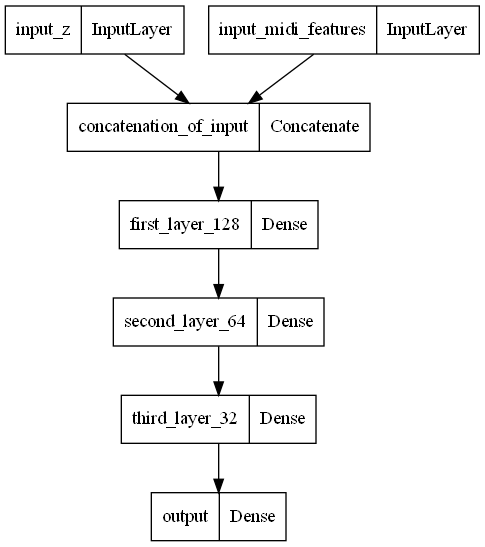

In [92]:
plot_model(GAN.generator)

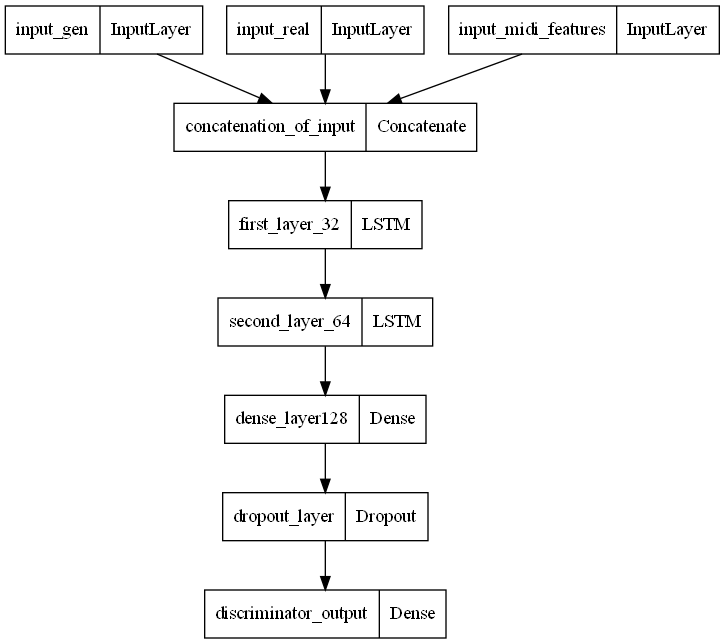

In [93]:
plot_model(GAN.discriminator)

In [94]:
GAN.create_and_train_gan(train_df, batch_size = 16, epochs=100, learning_rate=0.001, optimizer=optimizers.Adam)

epoch number 0 , [D loss: 0.626189] [G loss: 1.123176]
epoch number 1 , [D loss: 0.376532] [G loss: 1.667573]
epoch number 2 , [D loss: 1.128591] [G loss: 1.667387]
epoch number 3 , [D loss: 0.984604] [G loss: 1.672525]
epoch number 4 , [D loss: 0.524910] [G loss: 1.329713]
epoch number 5 , [D loss: 0.582465] [G loss: 1.217198]
epoch number 6 , [D loss: 0.708463] [G loss: 1.033210]
epoch number 7 , [D loss: 0.684055] [G loss: 1.021241]
epoch number 8 , [D loss: 0.651450] [G loss: 1.070988]
epoch number 9 , [D loss: 0.729229] [G loss: 1.100663]
epoch number 10 , [D loss: 0.627295] [G loss: 1.117722]
epoch number 11 , [D loss: 0.744825] [G loss: 1.112209]
epoch number 12 , [D loss: 0.767057] [G loss: 1.119914]
epoch number 13 , [D loss: 0.767401] [G loss: 1.141095]
epoch number 14 , [D loss: 0.643359] [G loss: 1.072109]
epoch number 15 , [D loss: 0.648487] [G loss: 1.065397]
epoch number 16 , [D loss: 0.734778] [G loss: 1.061042]
epoch number 17 , [D loss: 0.735411] [G loss: 1.093316]
ep

In [266]:
GAN.show_gan()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_z (InputLayer)           [(None, 1, 300)]     0           []                               
                                                                                                  
 input_midi_features (InputLaye  [(None, 1, 7)]      0           []                               
 r)                                                                                               
                                                                                                  
 Generator (Functional)         (None, 1, 300)       59660       ['input_z[0][0]',                
                                                                  'input_midi_features[0][0]']    
                                                                                                

In [267]:
# import pickle
# # Pickle the list
# with open('disc_loss.pickle', 'wb') as f:
#     pickle.dump(GAN.disc_loss, f)

# # Pickle the list
# with open('gen_loss.pickle', 'wb') as f:
#     pickle.dump(GAN.gen_loss, f)

In [89]:
GAN.plot_loss()

In [284]:
for _, song in test_df.iterrows():
    GAN.predict_lyrics_for_single_song(song, num_of_words_to_predict = 50)

1/1 [==============================] - 0s 33ms/step
oh coz i i another who a for 


cause says here we me okay 


tonight it for 


your im my mover only 


the are bebopalula  


with theres the my things that 


and aint she my had to be 


when what in when runnin she someones 


her sight jokes what 


1/1 [==============================] - 0s 46ms/step
way to you the but 


the up and if to 


cause outta ring but love me the bitch dreams 


wars might clouds away me get 


out you get on i it to 


we you cause dong you draw is you theres 


light we we verse cause them 


for we blue 


1/1 [==============================] - 0s 42ms/step
generation simple down it a blue be 


it dr a liar say thing follow 


in out you up but 


get and wasabe smile he was on she 


my so o you needs any 


not blue your nigga me are a shining 


of away until your in me 


you i even 


1/1 [==============================] - 0s 34ms/step
stay that 


going light 


you and slide as you but too 

### 3.2 GAN with LSTM's weight TRAINABLE

In [29]:
GAN = GAN_Lyrics_Generator(model_melody_per_song, train_lstm = True)

In [27]:
GAN.create_and_train_gan(train_df, batch_size = 8, epochs=100, learning_rate=0.001, optimizer=optimizers.Adam)

epoch number 0 , [D loss: 0.800629] [G loss: 1.304221]
epoch number 1 , [D loss: 0.660555] [G loss: 1.947493]
epoch number 2 , [D loss: 0.207686] [G loss: 2.756545]
epoch number 3 , [D loss: 0.543752] [G loss: 1.986199]
epoch number 4 , [D loss: 0.412492] [G loss: 2.103874]
epoch number 5 , [D loss: 0.513413] [G loss: 1.971640]
epoch number 6 , [D loss: 0.288391] [G loss: 3.063819]
epoch number 7 , [D loss: 0.291943] [G loss: 2.532311]
epoch number 8 , [D loss: 0.675205] [G loss: 1.583015]
epoch number 9 , [D loss: 0.492656] [G loss: 1.870920]
epoch number 10 , [D loss: 0.868293] [G loss: 1.570154]
epoch number 11 , [D loss: 0.640656] [G loss: 2.285330]
epoch number 12 , [D loss: 0.537097] [G loss: 1.916484]
epoch number 13 , [D loss: 0.308276] [G loss: 2.631794]
epoch number 14 , [D loss: 0.455387] [G loss: 2.058688]
epoch number 15 , [D loss: 0.360834] [G loss: 2.053675]
epoch number 16 , [D loss: 0.351982] [G loss: 2.341696]
epoch number 17 , [D loss: 0.540428] [G loss: 1.603070]
ep

In [286]:
GAN.show_gan()

Model: "GAN"
__________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_z (InputLayer)           [(None, 1, 300)]     0           []                               
                                                                                                  
 input_midi_features (InputLaye  [(None, 1, 7)]      0           []                               
 r)                                                                                               
                                                                                                  
 Generator (Functional)         (None, 1, 300)       59660       ['input_z[0][0]',                
                                                                  'input_midi_features[0][0]']    
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1, 300)       0       

In [28]:
GAN.plot_loss()

In [283]:
for _, song in test_df.iterrows():
    GAN.predict_lyrics_for_single_song(song, num_of_words_to_predict = 50)

1/1 [==============================] - 0s 36ms/step
is with gotta so simon if a minute 


we she to we dont it 


when that with 


am i a more thats 


be cause and away 


then there were than up are 


like no better from he dressed a 


york another another my cat not okay 


thats whats the slip 


1/1 [==============================] - 0s 32ms/step
im help a it on 


train that whats was for 


what baby bottle other a im the on for 


i so on the and we 


right stan no to be race oh 


a a little I dreams special about a better 


why i the when me to 


give thats on 


1/1 [==============================] - 0s 55ms/step
another it red t you dont see 


me is with the up with cryin 


i everybody you that to 


news are york a some i the get 


i woohoo in around it i 


dream thing friend since days aboard with your 


old dream so who be the 


the i holdin 


1/1 [==============================] - 0s 49ms/step
like i 


a daa 


be how and all no i you to 


inside a 


i w